In [79]:
import os
import pandas as pd 
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, cross_val_score
# from sklearn.manifold import TSNE
import hdbscan as hdb
import matplotlib  as mpl
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms
%matplotlib inline
import os, shutil, glob
from PIL import Image
from itertools import cycle
from random import randint
import re, math
import seaborn as sns; sns.set_style("white")
import umap as umap
import datetime
import gc
from pathlib import Path

# import plotnine as gg
# from cytominer_eval import evaluate
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.io as pio
pio.renderers

os.getcwd()

'/scratch2-shared/david/spherebooks'

In [80]:
figformat = 'png'
dpi = 300
statarg = 'single'
OutputDir = f'./output/3_PCAUMAP'
if not os.path.exists(OutputDir): 
    os.makedirs(OutputDir)
FeatureDir = './output/2_FIM'
trainarg = 'all'

In [81]:
def confidence_ellipse(x, y, ax, n_std=2.0, facecolor='none', **kwargs):

    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])

    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    
    return ax.add_patch(ellipse)


In [82]:
# AllFrameNdarray = AllFrames.to_numpy(copy=True)
# df2npy = frameFeatures.drop(columns=['DRUG_NAME'])
# frameNpy = df2npy.to_numpy()
read_data = pd.read_parquet('output/2_FIM/spheroidSingleCell.parquet')
# arglist = ['BzCl 100', 'Stauro 2', 'FCCP 10', 'DMSO']
cbar = pd.DataFrame()
# training_data = training_data[training_data['drug'].isin(arglist)]
read_data.reset_index(inplace=True, drop = True)
# training_data.drop(columns=['drug_name', 'ImageNumber_nuclei', 'Metadata_Site_nuclei'], inplace=True)

In [83]:
training_data = read_data.copy()

#
# training_data = training_data.loc[:,~training_data.columns.str.contains('AreaShape_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Correlation_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Granularity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Intensity_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('RadialDistribution_', case=False)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=False)]
# loc_dataX = training_data.loc[:,training_data.columns.str.contains('_X', case=True)]
# loc_dataX = loc_dataX.copy()
# loc_dataY = training_data.loc[:,training_data.columns.str.contains('_Y', case=True)]
# loc_dataY = loc_dataY.copy()
loc_data = training_data[['Nuclei_Location_Center_X','Nuclei_Location_Center_Y']]
# loc_data = loc_data - loc_data.mean()
# loc_data['loc_R'] = loc_data.apply(lambda x: (x['Nuclei_Location_Center_X']**2 + x['Nuclei_Location_Center_Y']**2)**0.5, axis = 1)
training_data = training_data.loc[:,~training_data.columns.str.contains('Location', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('ObjectNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('ImageNumber_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Parent', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('Children', case=True)]
# training_data = training_data.loc[:,~training_data.columns.str.contains('Neighbors_', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_ObjectNumber', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Object_Number', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_Y', case=True)]
training_data = training_data.loc[:,~training_data.columns.str.contains('_X', case=True)]
# zplane = training_data['Metadata_Plane'].pop()
df_norm = training_data.select_dtypes(include=np.number)
df_norm = df_norm.loc[:,~df_norm.columns.str.contains('Metadata_', case=True)]
df_norm = (df_norm-df_norm.min())/(df_norm.max()-df_norm.min()) 
df_norm = df_norm.fillna(0)
training_data[df_norm.columns] = df_norm

#Correlation contains some kind of well information

# feature_groups = ['AreaShape'
#                   , 'Correlation'
#                   , 'Granularity'
#                   , 'Intensity'
#                   , 'Neighbors'
#                   , 'RadialDistribution'
#                   ]
# real_names = [x for x in training_data.columns if x.split('_')[0] in feature_groups]
# training_data = training_data[real_names]
training_data_out = training_data
# training_data['Metadata_Plane'] = zplane

toNpy = training_data.loc[:,~training_data.columns.str.contains('Metadata_')]
toNpy.reset_index(inplace=True, drop=True)

# training_data.dropna(axis=1, inplace=True)
training_data_out.to_csv('training_data.csv', sep=';')

In [84]:
# toframe = training_data.drop(columns=['drug_name'])
#Always gonna be 1

dataNpy = toNpy.to_numpy()
colnames = toNpy.columns
# del read_data
# del toNpy
# del training_data_out
# gc.collect()


In [85]:
loc_data

,Nuclei_Location_Center_X,Nuclei_Location_Center_Y
0,465.299771,380.979405
1,447.143452,377.621429
2,509.344622,384.220120
3,521.828571,332.767619
4,465.418890,337.912040
...,...,...
2361,489.106322,677.592912
2362,524.985217,711.695568
2363,558.395615,693.104862
2364,597.718644,700.926554


In [86]:
np.isnan(dataNpy).any()

False

In [87]:
# perplex = 20

variant = 'PCA_All'


pca_model = PCA(n_components=  2)
pca_model = pca_model.fit(dataNpy)
pcaOut = pca_model.transform(dataNpy)

umap_model = umap.UMAP(n_neighbors=15
                       #, min_dist=0.5
                       )
umapOut = umap_model.fit_transform(dataNpy)

labels = hdb.HDBSCAN(
    min_samples=10,
    min_cluster_size=70,
).fit_predict(umapOut)
training_data = training_data.copy()
training_data['pc1'] = pcaOut[:,0]
training_data['pc2'] = pcaOut[:,1]

training_data['umap1'] = umapOut[:,0]
training_data['umap2'] = umapOut[:,1]
training_data['cluster'] = labels
training_data['loc_X'] = loc_data['Nuclei_Location_Center_X']
training_data['loc_Y'] = loc_data['Nuclei_Location_Center_Y']
# training_data['loc_R'] = loc_data['loc_R']

In [88]:
fig = plt.figure(figsize=[14, 5])
ax = fig.add_subplot(121)
ax.set_xlabel('PC 1', fontsize = 10)
ax.set_ylabel('PC 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
cmap = sns.color_palette("hls")
hue = training_data['Metadata_Well']
# hue = training_data['cluster']
sns.scatterplot(x="pc1", y="pc2",
                    palette=cmap, hue=hue,
                    data=training_data).set(title=f'pca all'
            )
ax.set_facecolor('w')
ax.get_legend().remove()
ax = fig.add_subplot(122)
ax.set_xlabel('UMAP 1', fontsize = 10)
ax.set_ylabel('UMAP 2', fontsize = 10)
ax.spines['top'].set_color('w')
ax.spines['right'].set_color('w')
ax.spines['left'].set_color('grey')
ax.spines['bottom'].set_color('grey')
sns.scatterplot(x="umap1", y="umap2",
                    palette=cmap, hue=hue,
                    data=training_data).set(title=f'umap all'
            )
ax.set_facecolor('w')
plt.savefig(f'{OutputDir}/all.png')
# ax.get_legend().remove()
plt.close()

/tmp/ipykernel_396147/3398088944.py:12: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.

/tmp/ipykernel_396147/3398088944.py:25: UserWarning:

The palette list has more values (6) than needed (5), which may not be intended.



In [89]:
# xlimPCA = [training_data['pc1'].min() - 0.2*abs(training_data['pc1'].min()), training_data['pc1'].max() + 0.2*abs(training_data['pc1'].max())]
# ylimPCA = [training_data['pc2'].min() - 0.2*abs(training_data['pc2'].min()), training_data['pc2'].max() + 0.2*abs(training_data['pc2'].max())]
# xlimUMAP = [training_data['umap1'].min() - 2, training_data['umap1'].max() + 0.2*abs(training_data['umap1'].max())]
# ylimUMAP = [training_data['umap2'].min() - 2, training_data['umap2'].max() + 0.2*abs(training_data['umap2'].max())]

In [92]:
df = training_data
df = df.loc[:,~df.columns.str.contains('umap|pca|cluster')]
well_list = df['Metadata_Well'].unique()

well: A01


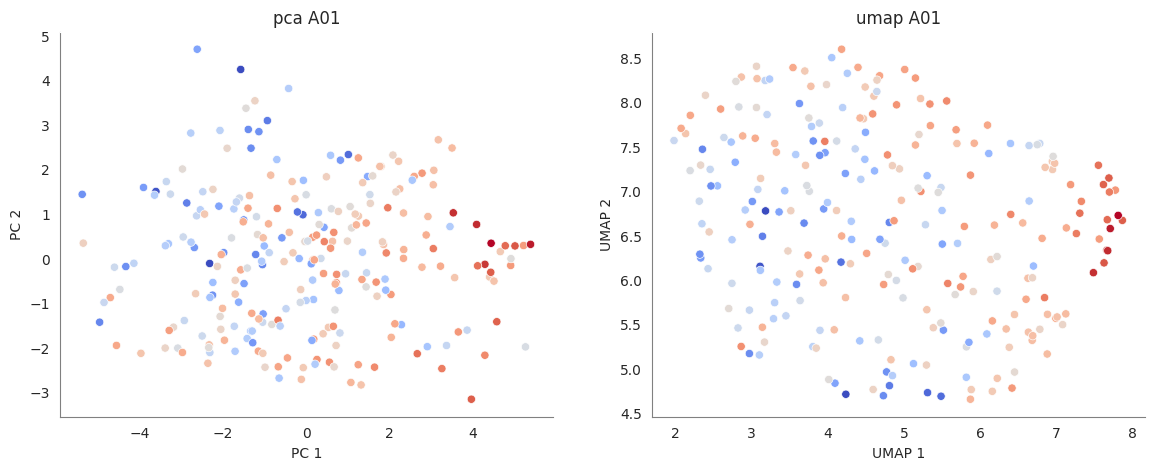

well: A02


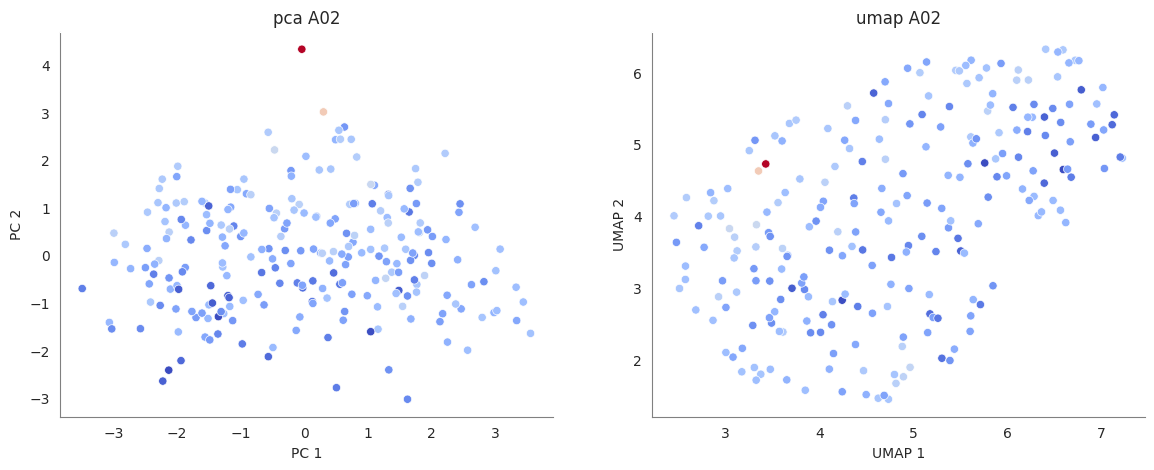

well: A03


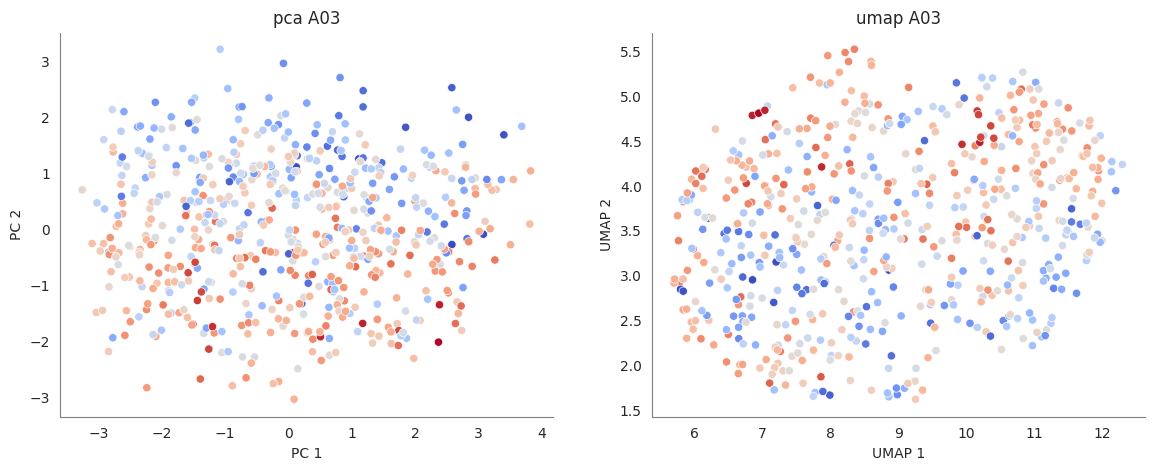

well: A04


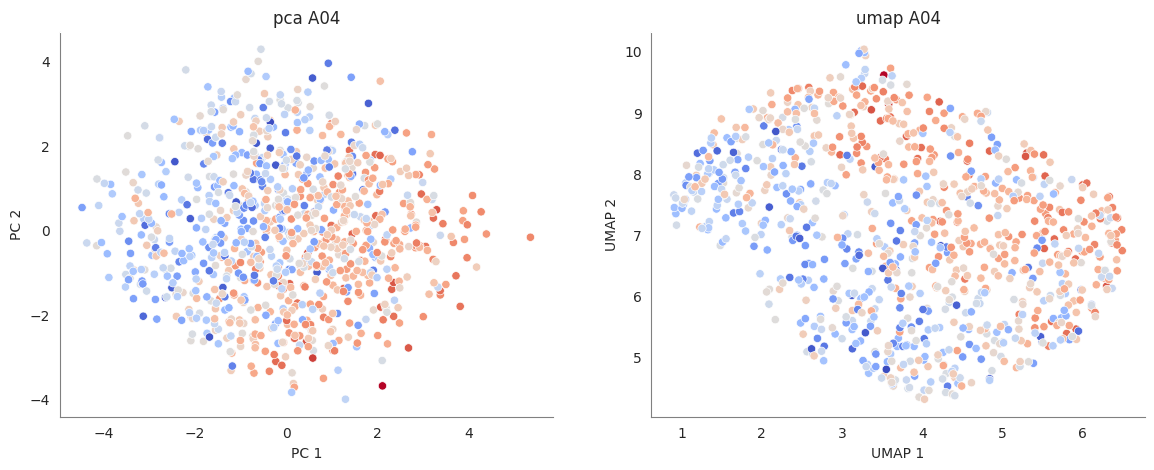

well: A05


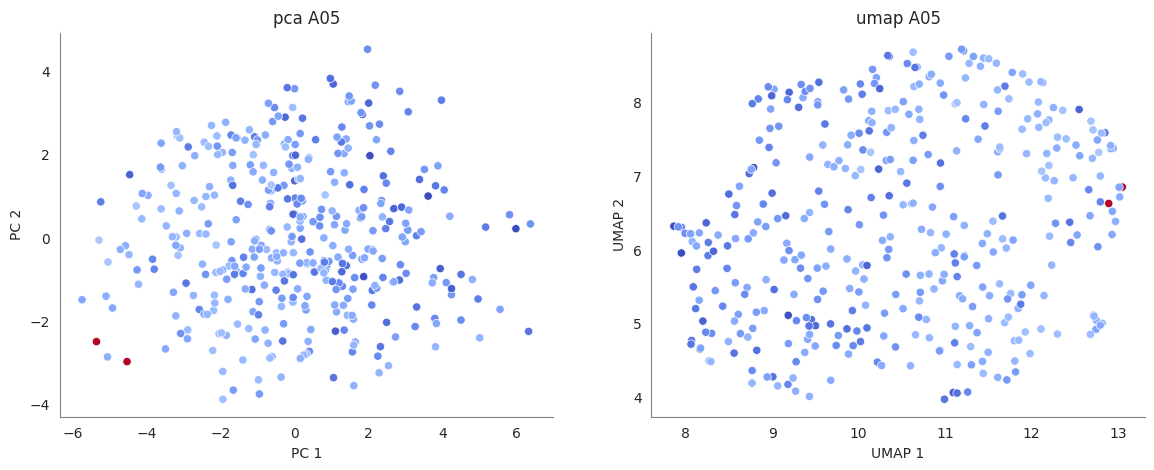

In [115]:
for well in well_list:
    print(f'well: {well}')
    dfwell = df[df['Metadata_Well'].str.contains(well)]
    dfwell.reset_index(inplace=True, drop=True)
    dfwell = dfwell.copy()
    quanX = dfwell['loc_X'].quantile(0.95)
    quanY = dfwell['loc_Y'].quantile(0.95)

    xmean = dfwell[dfwell['loc_X'] < quanX]
    xmean = xmean['loc_X']
    xmean = xmean.mean()

    ymean = dfwell[dfwell['loc_Y'] < quanY]
    ymean = ymean['loc_Y']
    ymean = ymean.mean()

    dfwell['loc_X'] = dfwell['loc_X'] - xmean
    dfwell['loc_Y'] = dfwell['loc_Y'] - ymean


    dfwell['loc_R'] = dfwell.apply(lambda x: (x['loc_X']**2 + x['loc_Y']**2)**0.5, axis = 1)

    toNpy = dfwell.loc[:,~dfwell.columns.str.contains('Metadata_|_X|_Y|loc_R')]
    toNpy.reset_index(inplace=True, drop=True)
    dataNpy = toNpy.to_numpy()
    pca_model = PCA(n_components=  2)
    pca_model = pca_model.fit(dataNpy)
    pcaOut = pca_model.transform(dataNpy)

    umap_model = umap.UMAP(n_neighbors=25
                        #,min_dist=0.2
                        )
    umapOut = umap_model.fit_transform(dataNpy)

    labels = hdb.HDBSCAN(
        min_samples=10,
        min_cluster_size=50,
    ).fit_predict(umapOut)

    dfwell['pc1'] = pcaOut[:,0]
    dfwell['pc2'] = pcaOut[:,1]

    dfwell['umap1'] = umapOut[:,0]
    dfwell['umap2'] = umapOut[:,1]
    dfwell['cluster'] = labels

    fig = plt.figure(figsize=[14, 5])
    ax = fig.add_subplot(121)
    ax.set_xlabel('PC 1', fontsize = 10)
    ax.set_ylabel('PC 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    # cmap = sns.color_palette("hls")
    cmap = sns.color_palette("coolwarm", as_cmap=True)
    hue = dfwell['loc_R']
    sns.scatterplot(x="pc1", y="pc2",
                        palette=cmap, hue=hue,
                        data=dfwell).set(title=f'pca {well}'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    ax = fig.add_subplot(122)
    ax.set_xlabel('UMAP 1', fontsize = 10)
    ax.set_ylabel('UMAP 2', fontsize = 10)
    ax.spines['top'].set_color('w')
    ax.spines['right'].set_color('w')
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    sns.scatterplot(x="umap1", y="umap2",
                        palette=cmap, hue=hue,
                        data=dfwell).set(title=f'umap {well}'
                )
    ax.set_facecolor('w')
    ax.get_legend().remove()
    plt.savefig(f'{OutputDir}/{well}.png')
    plt.show()
    plt.close()
    

In [112]:
tdf = dfwell[dfwell['loc_X'] < quanX]
tdf = tdf['loc_X']
tdf = tdf.mean()

In [114]:
dfwell['loc_X'] - tdf

0       7.370032
1     -10.786287
2      51.414882
3      63.898832
4       7.489151
         ...    
243   -31.150610
244    44.429738
245   -52.196575
246   -27.488879
247    16.904432
Name: loc_X, Length: 248, dtype: float64